In [1]:
# ensure plots print without needing to call show()
%matplotlib inline

In [2]:
# import our packages
from typing import List, Tuple
import pandas
import numpy
import sys

import wvpy.util

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

In [3]:

from augmented_model import mk_modeling_fns

In [4]:
# training hyper-parameters
# often searching, on simulated out of sample data,
# for good values of these can improve model quality.
epochs = 200
batch_size = 512
validation_split = 0.2
n_hidden_models = 10
black_box_model = False
simple_model = False

In [5]:
# get our data and language model through data adaptors
sys.path.append('.')


In [6]:
# make training data suited to our modeling idea
def mk_data(
    n: int,
    *,
    selector_models: numpy.ndarray,
    sub_models: numpy.ndarray,
) -> Tuple[numpy.ndarray, numpy.ndarray]:
    """
    Make synthetic data 

    :param n: number of rows to create
    :param selector_models: models that pick different per-row behaviors. shape[0] is number of sub-systems, shape[1] is problem dimension.
    :param sub_models: per-row behaviors. sub_models.shape must equal selector models.shape.
    :return: tuple of explanatory and outcome variables.
    """
    assert selector_models.shape == sub_models.shape
    width = selector_models.shape[1]
    x = numpy.random.normal(size = (n, width))
    # affinity[i, j] is x[i, :] . selector_models[j]
    affinity = numpy.matmul(x, selector_models.T)
    # get per-row maximums
    selections = numpy.argmax(affinity, axis=1)
    # mpred[i, j] is x[i, :]. sub_models[j]
    mpred = numpy.matmul(x, sub_models.T)
    # use a sub_model with maximum selector value as our link prediction
    link_values = mpred[range(mpred.shape[0]), selections]
    y = numpy.array(link_values > 0, dtype=int)
    return x, y



In [7]:
n_behaviors = 5
problem_dim = 20
selector_models = numpy.random.normal(size=(n_behaviors, problem_dim))
sub_models = numpy.random.normal(size=(n_behaviors, problem_dim))

In [8]:
train_x, train_y = mk_data(25000, selector_models=selector_models, sub_models=sub_models)
test_x, test_y = mk_data(25000, selector_models=selector_models, sub_models=sub_models)

In [9]:
# show how many training examples
train_x.shape

(25000, 20)

In [10]:
# show how many test examples
test_x.shape


(25000, 20)

In [11]:
mk_model, augment_training_output, unwrap_predictions = mk_modeling_fns(
    simple_model=simple_model,
    black_box_model=black_box_model,
    n_hidden_models=n_hidden_models)

In [12]:
augmented_model = mk_model(encode_dim=train_x.shape[1])
# augmented_model.summary()

2022-03-15 14:39:32.596616: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
%%capture
# do the training on our first model, only training data
history_big = augmented_model.fit(
    train_x,
    train_y,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split)

In [14]:
trajectory = pandas.DataFrame(history_big.history)
trajectory['epoch'] = range(trajectory.shape[0])

trajectory_plot = trajectory.melt(
    id_vars=['epoch'],
    value_vars=['loss', 'val_loss'],
    var_name='data set',
    value_name='estimated loss',
)

Text(0.5, 1.0, 'model loss as a function of epoch\n(smaller better)')

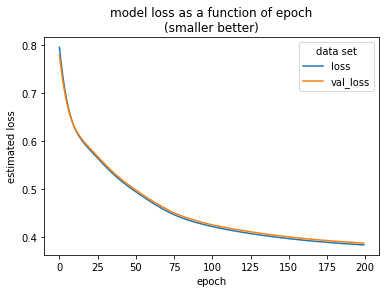

In [15]:
sns.lineplot(
    data=trajectory_plot,
    x='epoch',
    y='estimated loss',
    hue = 'data set',
)
plt.title("model loss as a function of epoch\n(smaller better)")

In [16]:
# get predictions on data not seen during training!
pred_test = augmented_model.predict(test_x)

In [17]:
pred_test


array([[0.27485552, 0.35647273],
       [0.9998821 , 0.65255576],
       [0.0464723 , 0.7170802 ],
       ...,
       [0.09786533, 0.40187472],
       [0.25924492, 0.7240664 ],
       [0.4929602 , 0.520334  ]], dtype=float32)

In [18]:
pred_test_frame = unwrap_predictions(pred_test)

pred_test_frame['truth'] = test_y

In [19]:
pred_test_frame

,prediction_augmented,prediction,truth
0,0.274856,0.356473,0
1,0.999882,0.652556,1
2,0.046472,0.717080,0
3,0.999540,0.280418,1
4,0.004015,0.179256,0
...,...,...,...
24995,0.000025,0.226204,0
24996,0.999655,0.590619,1
24997,0.097865,0.401875,0
24998,0.259245,0.724066,0


In [20]:
pred_test_frame.describe()

,prediction_augmented,prediction,truth
count,2.500000e+04,25000.000000,25000.000000
mean,4.984433e-01,0.499537,0.501240
std,4.136898e-01,0.173847,0.500008
min,4.011945e-11,0.037156,0.000000
25%,3.835704e-02,0.371310,0.000000
50%,4.987695e-01,0.498552,1.000000
75%,9.615413e-01,0.630096,1.000000
max,1.000000e+00,0.954641,1.000000


Our hope is, that this more complicated model can improve predictions. Note: this is not likely to be very profitable when using the same sort of logistic regression for both the model and the fusion or mixture control. This is becaues of the low utility of residuals in linear models. For purposes of demonstration, we will try the experiment anyway.


The observed effect is weak, a basic logistic regression gets a test deviance of 0.712 (lower is better)- and this could probably be acheived by mere regularization. But we do see identification of lower quality predictions and a slight improvement. The next step is data augmentation, where we combine positive and negative examples to build deliberately ambiguous training instances. (Note: ambiguous data augmentation could be tried on the original logistic regression also!) We also have the issue of having slowed down training (so number of epochs may not be comparable) and having introduced new hyperparameters.

This model moderately out-performs our basic logistic regression example (02_IMDB_sentiment/IMDB_sentiment.ipynb) which has a deviance of 0.712 (lower is better)

In [21]:
wvpy.util.mean_deviance(
    predictions=pred_test_frame['prediction'],
    istrue=pred_test_frame['truth']
)

1.2600074482923747

In [22]:
wvpy.util.mean_deviance(
    predictions=pred_test_frame['prediction_augmented'],
    istrue=pred_test_frame['truth']
)

0.27982390588940687

<Figure size 432x288 with 0 Axes>

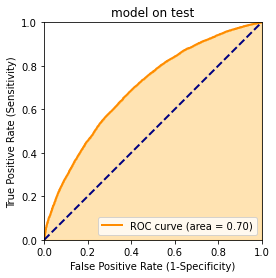

0.6989557804576321

In [23]:
# evaluate the results
wvpy.util.plot_roc(
    pred_test_frame['prediction'],
    pred_test_frame['truth'],
    title='model on test')


<Figure size 432x288 with 0 Axes>

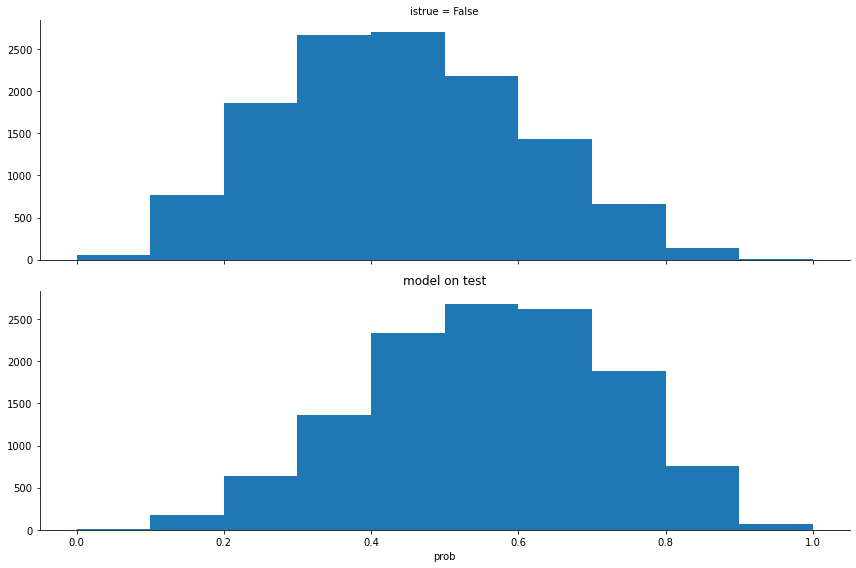

In [24]:
# evaluate the results
wvpy.util.dual_hist_plot(
    pred_test_frame['prediction'],
    pred_test_frame['truth'],
    truth_target=1,
    title='model on test')


In [25]:
pandas.crosstab(
    pred_test_frame['truth'] > 0.5,
    pred_test_frame['prediction'] > 0.5)



prediction,False,True
truth,,
False,8053,4416
True,4516,8015


<Figure size 432x288 with 0 Axes>

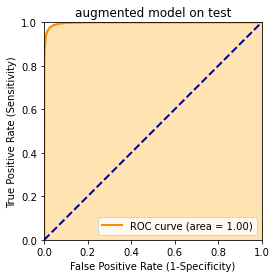

0.9976659824448584

In [26]:
# evaluate the results
wvpy.util.plot_roc(
    pred_test_frame['prediction_augmented'],
    pred_test_frame['truth'],
    title='augmented model on test')

<Figure size 432x288 with 0 Axes>

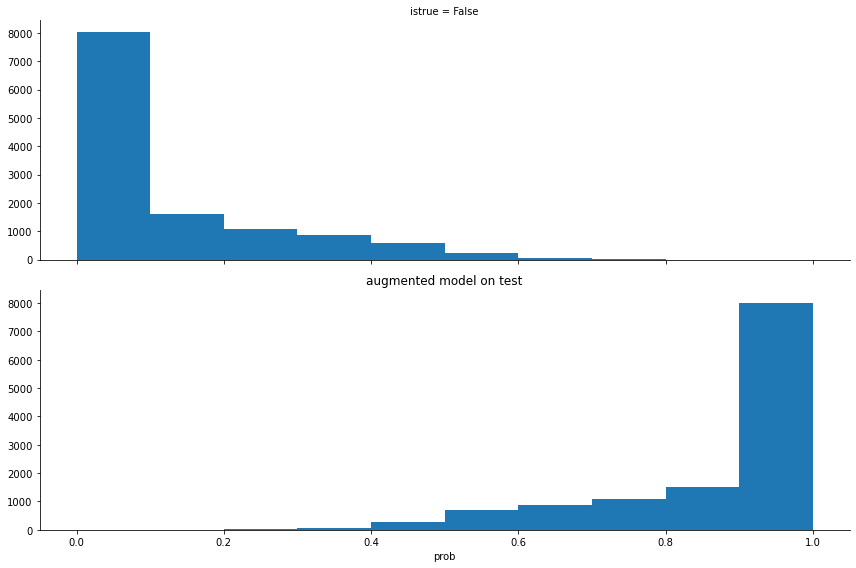

In [27]:
# evaluate the results
wvpy.util.dual_hist_plot(
    pred_test_frame['prediction_augmented'],
    pred_test_frame['truth'],
    truth_target=1,
    title='augmented model on test')

In [28]:
pandas.crosstab(
    pred_test_frame['truth'] > 0.5,
    pred_test_frame['prediction_augmented'] > 0.5)

prediction_augmented,False,True
truth,,
False,12179,290
True,331,12200


Copyright &copy; 2019-2022 Win-Vector LLC.  All rights reserved. [http://www.win-vector.com](http://www.win-vector.com)